In [1]:
import os
import random
import time
import glob
import json
import dit
import itertools
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns;sns.set()
import pandas as pd
from dit import Distribution
from scipy.optimize import minimize
os.chdir("../")
from helpers.group_helpers import classify_syms, srv_to_mat
from helpers.compare_helpers import appendtoPXS,load_frame,addbestsym
from helpers.helpers import SeabornFig2Grid
from jointpdfpython3.measures import synergistic_entropy_upper_bound, append_random_srv
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")

In [4]:
states = 5
dist_type = 'uniform'
ds = []
folder = '../../results/rq11/'
os.chdir(folder)
name = dist_type +'states'+str(states)
allfiles = glob.glob("*.pkl")
files = [file for file in allfiles if name in file]
if len(files) != 0:
    print(files)
    ds.append(pd.concat([pd.read_pickle(f) for f in files]))
os.chdir('../../code/plot_notebooks')
d = pd.concat(ds)
df = load_frame(d=d)

keepkeys = ['exp_sort', 'systemID', 'syn_upper', 'shapeS', 'srv_data', 'pX', 'parXY',
       'I(X1;X2)', 'runID', 'tot_runtime', 'syn_info', 'lenX', 'lenY',
       'states', 'dist_type', 'tot_repeats', 'mm', 
       'H(X0)', 'H(X1)', 'H(S)', 'I(X;S)', 'I(Xi;S)', 'pXS', 'WMS(X;S)']
df=df[keepkeys]
len(df)

ValueError: No objects to concatenate

## jointpdf vs syndisc gridspec

C:\Users\enrik\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\enrik\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<class 'helpers.helpers.SeabornFig2Grid'> <class 'seaborn.axisgrid.JointGrid'> <class 'matplotlib.gridspec.SubplotSpec'>


C:\Users\enrik\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<class 'helpers.helpers.SeabornFig2Grid'> <class 'seaborn.axisgrid.JointGrid'> <class 'matplotlib.gridspec.SubplotSpec'>


C:\Users\enrik\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<class 'helpers.helpers.SeabornFig2Grid'> <class 'seaborn.axisgrid.JointGrid'> <class 'matplotlib.gridspec.SubplotSpec'>


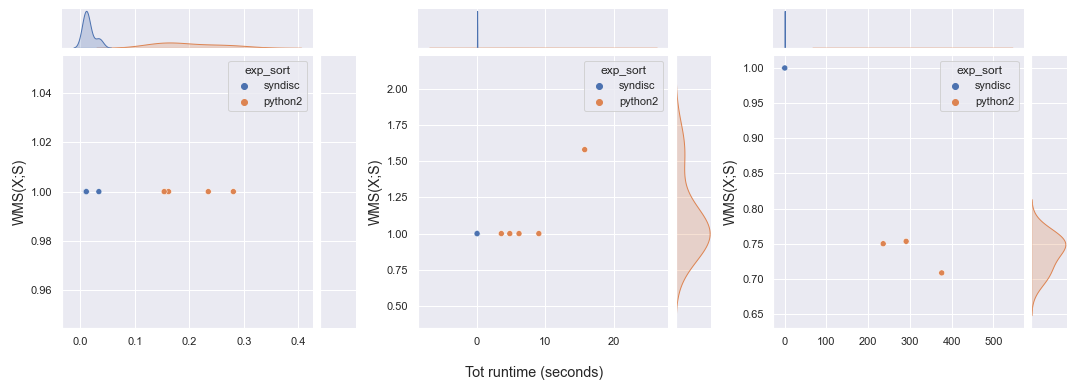

In [18]:
fig = plt.gcf()
fig.set_size_inches(15,7.5)
xlabel = 'tot_runtime'
ylabels = ['WMS(X;S)']
gs = gridspec.GridSpec(len(ylabels),len(states))
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i, idxs in enumerate(itertools.product(ylabels, states)):
    nrt, nvar = idxs
    g = sns.jointplot(data=d[d['states']==nvar], x=xlabel, y=nrt,hue='exp_sort'
                     ,marginal_ticks=False) 

    g.set_axis_labels(None,nrt,fontsize=14)
    m = SeabornFig2Grid(g, fig, gs[i])  
#     axeset_title('My Title', fontdict={'fontsize': 8, 'fontweight': 'medium'})
    print(type(m),type(g),type(gs[i]))
    # annotate subfig
#     g.ax_joint.annotate(f'$ states = {nvar:.0f}$',
#       xy=(0.05, 0.95), xycoords='axes fraction',
#       ha='right', va='center',
#       bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'black'})

fig.supxlabel("Tot runtime (seconds)")
gs.tight_layout(fig)
gs.update(top=0.7)
plt.show()
# fig.savefig('../../results/comparison/'+dist_type+'.png')
# os.chdir('../../code/plot_notebooks')


## load and run syndisc with previous pars


In [3]:
states=5
initdata = pd.read_pickle("../../results/rq11/randomstates"+str(states)+".pkl")
initdata=initdata[initdata['systemID'].isin([0,1,2,3,4])]
pars = initdata['parXY'].values
lenX=2
variables_X=np.arange(lenX)
data = {'systemID':[],'parXY':[],'pXS':[],'syn_upper':[],'runtime':[],'I(X;S)':[],'I(Xi;S)':[],'exp_sort':[]}
for i,p in enumerate(pars):
    print(i,time.strftime("%H:%M:%S", time.localtime()))
    data['systemID'].append(i)
    data['parXY'].append(p)
    jX = JointProbabilityMatrix(lenX,states)
    params2matrix_incremental(jX,p)
    pX = jX.joint_probabilities.joint_probabilities
    upper = initdata['syn_upper'].iloc[i]    
    ditjX = dit.Distribution.from_ndarray(pX)
    try:
        before = time.time()
        syn, probs = self_disclosure_channel(ditjX)
        data['runtime'].append(time.time()-before)

        vgx = probs['pVgX']
        x = initdata['pX'].iloc[i]
        pXS = np.reshape((x*vgx).T, [states]*lenX+[len(x*vgx)])
        dit_XS = Distribution.from_ndarray(pXS)
        synvars = list(range(lenX,len(dit_XS.rvs)))
        data['pXS'].append(pXS)
        data['I(X;S)'].append(dit.shannon.mutual_information(dit_XS,variables_X,synvars))
        data['I(Xi;S)'].append(sum([dit.shannon.mutual_information(dit_XS,[i],synvars) for i in variables_X]))
    except:
        print("syndisc error")
        data['pXS'].append([])
        data['I(X;S)'].append(0)
        data['I(Xi;S)'].append(0)
    data['exp_sort'].append('syndisc')
    data['syn_upper'].append(upper)
        
pddata = pd.DataFrame(data=data)
pddata.to_pickle("../../results/test/syndiscrandomstates"+str(states)+".pkl") 


0 01:03:56
1 02:09:16
2 03:09:58
3 04:42:15
4 05:44:53


## load data and plot

In [59]:
states = [2,3,4]
lenX = 2
subjects=np.arange(lenX)

dist_type = 'randomstates'
ds = []
folder = '../../results/rq11/'
os.chdir(folder)
allfiles = glob.glob("*.pkl")
if len(allfiles) != 0:
    for s in states:
        name = dist_type+str(s)
        files = [file for file in allfiles if name in file]
        print(files)
        ds.append(pd.concat([pd.read_pickle(f) for f in files]))
#         ds[-1]['states']=s
    os.chdir('../../code/plot_notebooks')
d = pd.concat(ds)
d.keys()

['randomstates2.pkl']
['randomstates3.pkl']
['randomstates4.pkl']


Index(['exp_sort', 'systemID', 'syn_upper', 'shapeS', 'srv_data', 'pX',
       'parXY', 'H(Xi)', 'I(X1;X2)', 'runID', 'tot_runtime', 'syn_info',
       'lenX', 'lenY', 'states', 'dist_type', 'num_srvs', 'systems', 'prev',
       'exp', 'save', 'folder', 'rowfolder', 'tot_repeats', 'mm',
       'summed_modulo', 'tol'],
      dtype='object')

Text(0.5, 1.0, 'random inputs X, states: [2, 3, 4]')

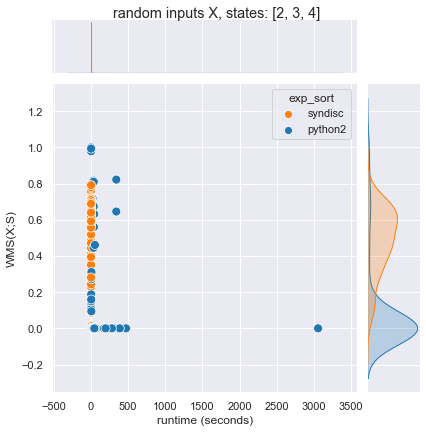

In [67]:
def wms(row):
    if row['exp_sort']=='syndisc':
        row['WMS(X;S)']=(row['I(X;S)']-row['I(Xi;S)'])/row['syn_upper']
        row['tot_runtime']=row['runtime']
    else:
        row['WMS(X;S)']=(row['syn_info'])/row['syn_upper']
    return row

firststates=d['states'].values[0]
if firststates==5:
    print(states)
    plot=d.apply(lambda row:wms(row),axis=1)
    plot['runtime (minutes)']=plot['tot_runtime']/60
else:
    plot = load_frame(d=d)
    plot['runtime (seconds)']=plot['tot_runtime']

xaxis='runtime (seconds)'
yaxis='WMS(X;S)'
hue='exp_sort'
f=sns.jointplot(data=plot,x=xaxis,y=yaxis,hue=hue,palette=['#ff7f0e','#1f77b4'],s=80)
f.fig.suptitle("random inputs X, states: "+str(states),y=1.0)

# f.ax_joint.set_xlabel('runtime (seconds)')
# plt.ylim(-0.1,plot['syn_info'].max()+0.1)
# f.ax_joint.set_xscale("log")